In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')

In [27]:
atlas = src.graph.graph_from_json('atlas.json')

In [4]:
cities = src.graph.graph_from_json('cities.json')

In [79]:
gdf = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [83]:
gdf[gdf['STATEFP'] == '06']

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
13,4,9,06,01779778,06,0400000US06,CA,California,00,G4000,A,403673296401,20291770234,+37.1551773,-119.5434183,"MULTIPOLYGON (((-119.99987 41.18397, -119.9998..."


In [6]:
graph_to_atlas, atlas_to_graph = src.adjacency.node_assignment(cities, atlas)

In [39]:
for node in atlas._node.values():
    node['visited'] = 0

In [7]:
deep_reload(src)

objective = src.routing.Objective(field = 'time')

t0 = time.time()

cost, values, paths = src.routing.all_pairs_shortest_paths(
    atlas, 
    [graph_to_atlas[n] for n in cities.nodes],
    objective = objective,
    method = 'dijkstra',
    return_paths = True,
)

print('\n')
print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 0.53 it/s, 30.03 s elapsed, 0.00 s remaining

Executed in 30.0308 seconds


In [38]:
len(paths[graph_to_atlas['Fresno']])

59226

In [41]:
destinations = [graph_to_atlas[n] for n in cities.nodes]

for origin in destinations:
    for destination in destinations:
        for node in paths[origin][destination]:

            atlas._node[node]['visited'] = 1

In [42]:
visited = 0

for node in atlas._node.values():
    if node['visited']:
        visited += 1

atlas.number_of_nodes(), visited

(59621, 19988)

In [65]:
cities_nodes = [n for n, v in graph._node.items() if v['type'] == 'city']
subgraph = src.graph.subgraph(graph, cities_nodes)

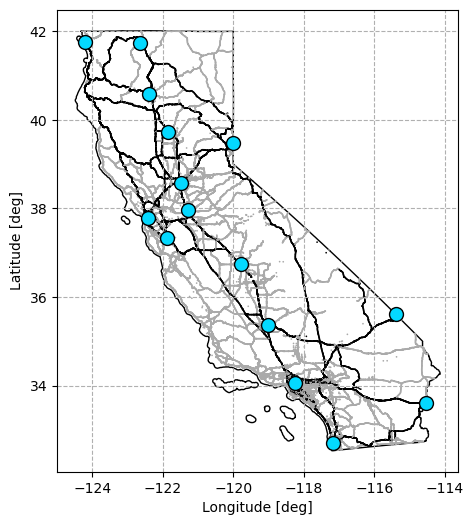

In [93]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'fc': 'none',
    'ec': 'k',
    'zorder': 0,
}

gdf[gdf['STATEFP'] == '06'].plot(ax = ax, **kw)


kw = {
    'show_links': False,
    'node_field': 'visited',
    'cmap': src.figures.colormap(['#aaaaaa', 'k']),
    'scatter': {
        's': 1.5,
        # 'fc': 'k',
        'ec': 'none',
        'zorder': 1,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 100,
        'fc': 'xkcd:neon blue',
        'ec': 'k',
        'zorder': 2,
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

ax.set(**{
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
})

ax.grid(ls = '--')

fig.savefig('Paper/figs/full_graph.png', bbox_inches = 'tight', dpi = 300)

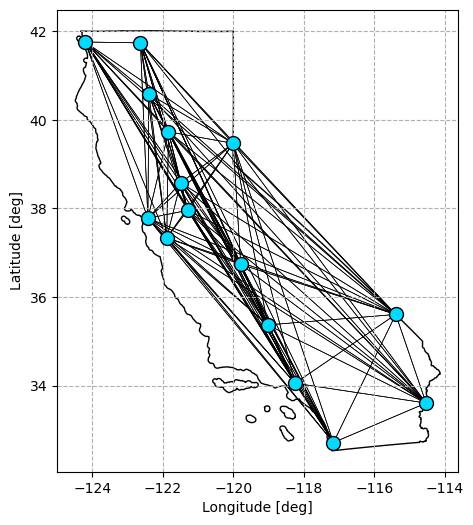

In [94]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'fc': 'none',
    'ec': 'k',
    'zorder': 0,
}

gdf[gdf['STATEFP'] == '06'].plot(ax = ax, **kw)



kw = {
    'show_links': True,
    'scatter': {
        's': 100,
        'fc': 'xkcd:neon blue',
        'ec': 'k',
        'zorder': 2,
    },
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
    },
}

src.figures.plot_graph(subgraph, ax = ax, **kw)

ax.set(**{
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
})

ax.grid(ls = '--')

fig.savefig('Paper/figs/reduced_graph.png', bbox_inches = 'tight', dpi = 300)

In [6]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(10))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

In [134]:
'''
Adding station objects
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    # max_charge_start_soc = 1,
    max_charge_start_soc = .5,
    risk_attitude = (.5, 1),
    cases = 30,
    # select_case = 6,
    # expectation = lambda x: x.mean(),
)

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            vehicle, chargers = node['n_dcfc']
        )

In [135]:
destinations = [n for n in graph.nodes if 'destination' in n]

In [136]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

cost_s, values_s, paths_s = src.routing.shortest_paths(
    graph, ['destination_0'],
    destinations = destinations,
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 1.5018 seconds


In [82]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

values_cases = []

for idx in range(30):

    _, values, _ = src.routing.shortest_paths(
        graph, ['destination_0'],
        destinations = destinations,
        objective = vehicle.select_case(idx),
        method = 'bellman',
        return_paths = True,
    )

    values_cases.append(values)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 2.4605 seconds


In [87]:
expected_costs = {}

for destination in destinations:

    expected_costs[destination] = values_s[destination]['time'].mean() / 3600

mean_costs = {}

for destination in destinations:

    mean_costs[destination] = np.array(
        [v[destination]['time'] for v in values_cases]
    ).mean() / 3600

In [88]:
expected_costs, mean_costs

({'destination_0': 0.0,
  'destination_1': 3.3457484070737906,
  'destination_2': 3.381515628885006,
  'destination_3': 0.04879970438683653,
  'destination_4': 2.3290034499346097,
  'destination_5': 3.9108835019110413,
  'destination_6': 0.5100423598869761,
  'destination_7': 3.7318800474647453,
  'destination_8': 0.3453691487950909,
  'destination_9': 2.3407993177387096,
  'destination_10': 1.2646149894766467,
  'destination_11': 2.0906230764428257,
  'destination_12': 0.9346209930307695,
  'destination_13': 1.3672406333204536,
  'destination_14': 2.0474382559234408},
 {'destination_0': 0.0,
  'destination_1': 3.382426592256392,
  'destination_2': 3.4112086608109453,
  'destination_3': 0.04879970438683649,
  'destination_4': 2.364411085289693,
  'destination_5': 3.996116320339047,
  'destination_6': 0.5100423598869758,
  'destination_7': 3.83966956991673,
  'destination_8': 0.34536914879509084,
  'destination_9': 2.377984652637042,
  'destination_10': 1.2646149894766472,
  'destinatio

In [14]:
'''
Running with Bellman with BEV stochastic vehicle objective - all pairs
'''
deep_reload(src)

t0 = time.time()

cost_s, values_s, paths_s = src.routing.all_pairs_shortest_paths(
    graph, [n for n in graph.nodes if 'destination' in n],
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print('\n')
print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 0.50 it/s, 32.23 s elapsed, 0.00 s remaining

Executed in 32.2285 seconds
